## Imports

In [49]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## TensorFlow GPU Check

In [50]:
# Check the tensorflow is detecting the gpu
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Hyperparameters

In [51]:
EPOCHS = 100
BATCH_SIZE = 16

# IMG_HEIGHT = 426
# IMG_WIDTH = 640

# Dataset directory
dataset_path = os.environ['DATASET_PATH']
#image_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.jpeg')]
directory_path = pathlib.Path(dataset_path)



## Loading the Dataset using Keras

In [52]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    # image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    # image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)


Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


## EDA (Exploratory Data Analysis)

In [53]:
# Prints the Total Number of Images in the Dataset
print(f'Number of Images: ', len(list(directory_path.glob('*/*.jpeg'))))

Number of Images:  24209


In [54]:
# Prints the classifications of Animals from the Dataset
class_names = train_ds.class_names
print(class_names)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [55]:
# Prints the Number of Images in each Class
for class_name in class_names:
    print(f'Number of {class_name} Images: ', len(list(directory_path.glob(f'{class_name}/*.jpeg'))))

Number of butterfly Images:  1650
Number of cat Images:  1227
Number of chicken Images:  3098
Number of cow Images:  1866
Number of dog Images:  4863
Number of elephant Images:  1079
Number of horse Images:  2623
Number of sheep Images:  1444
Number of spider Images:  4497
Number of squirrel Images:  1862


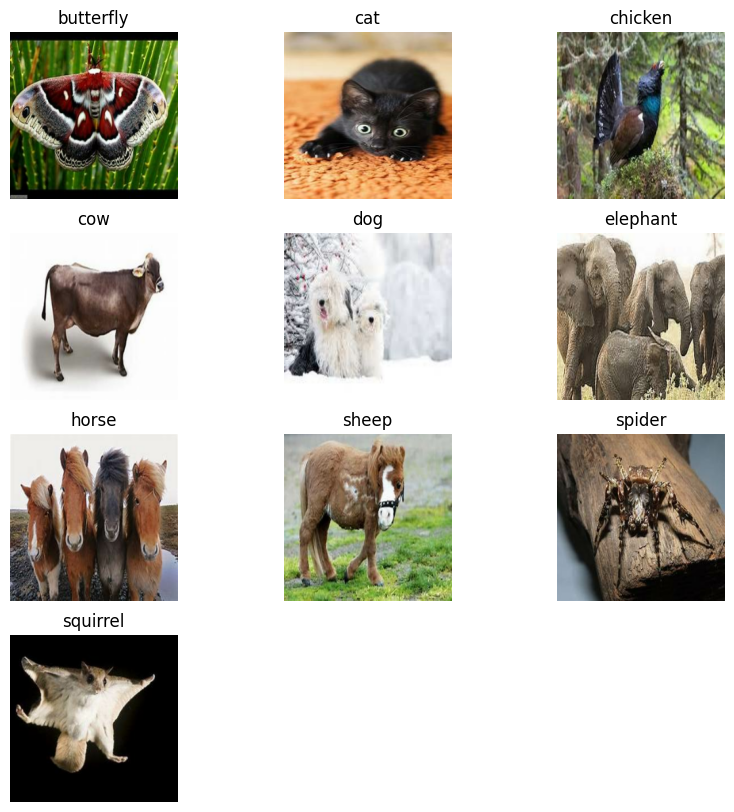

In [56]:
# Plots one image from each of the 10 classes
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(4, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

## Model

In [57]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 256, 256, 3)
(16,)


In [58]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [59]:
normalization_layer = layers.Rescaling(1./255)

In [60]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

4.02114e-05 0.99261075


### Model Creation

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])